# Library

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf


# 한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='white')

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#프로세스의 요구량만큼 메모리 사용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 시각화 함수 정의

In [3]:
# 0. 4069개 종류의 feature name 정보를 담은 dict 생성
feature_df = pd.read_csv('feature_df.csv')
feature_name = dict(zip(feature_df['feature'], feature_df['feature_name']))

X = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

# 1. 사망 / 생존 환자 인덱스
d_index = np.where(y==1)[0]
s_index = np.where(y==0)[0]

# 2. 사망 / 생존 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []

for d in range(10):
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def absum(top10_list):
    plt.figure(figsize = (12,10), dpi=150)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(4,4,1+i)
        plt.title(feature_name[f])
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='생존', linestyle=':', marker='o')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

((40680, 3), (40680, 3))

# M2 역전성 - 사망 / 생존 마커 TOP10
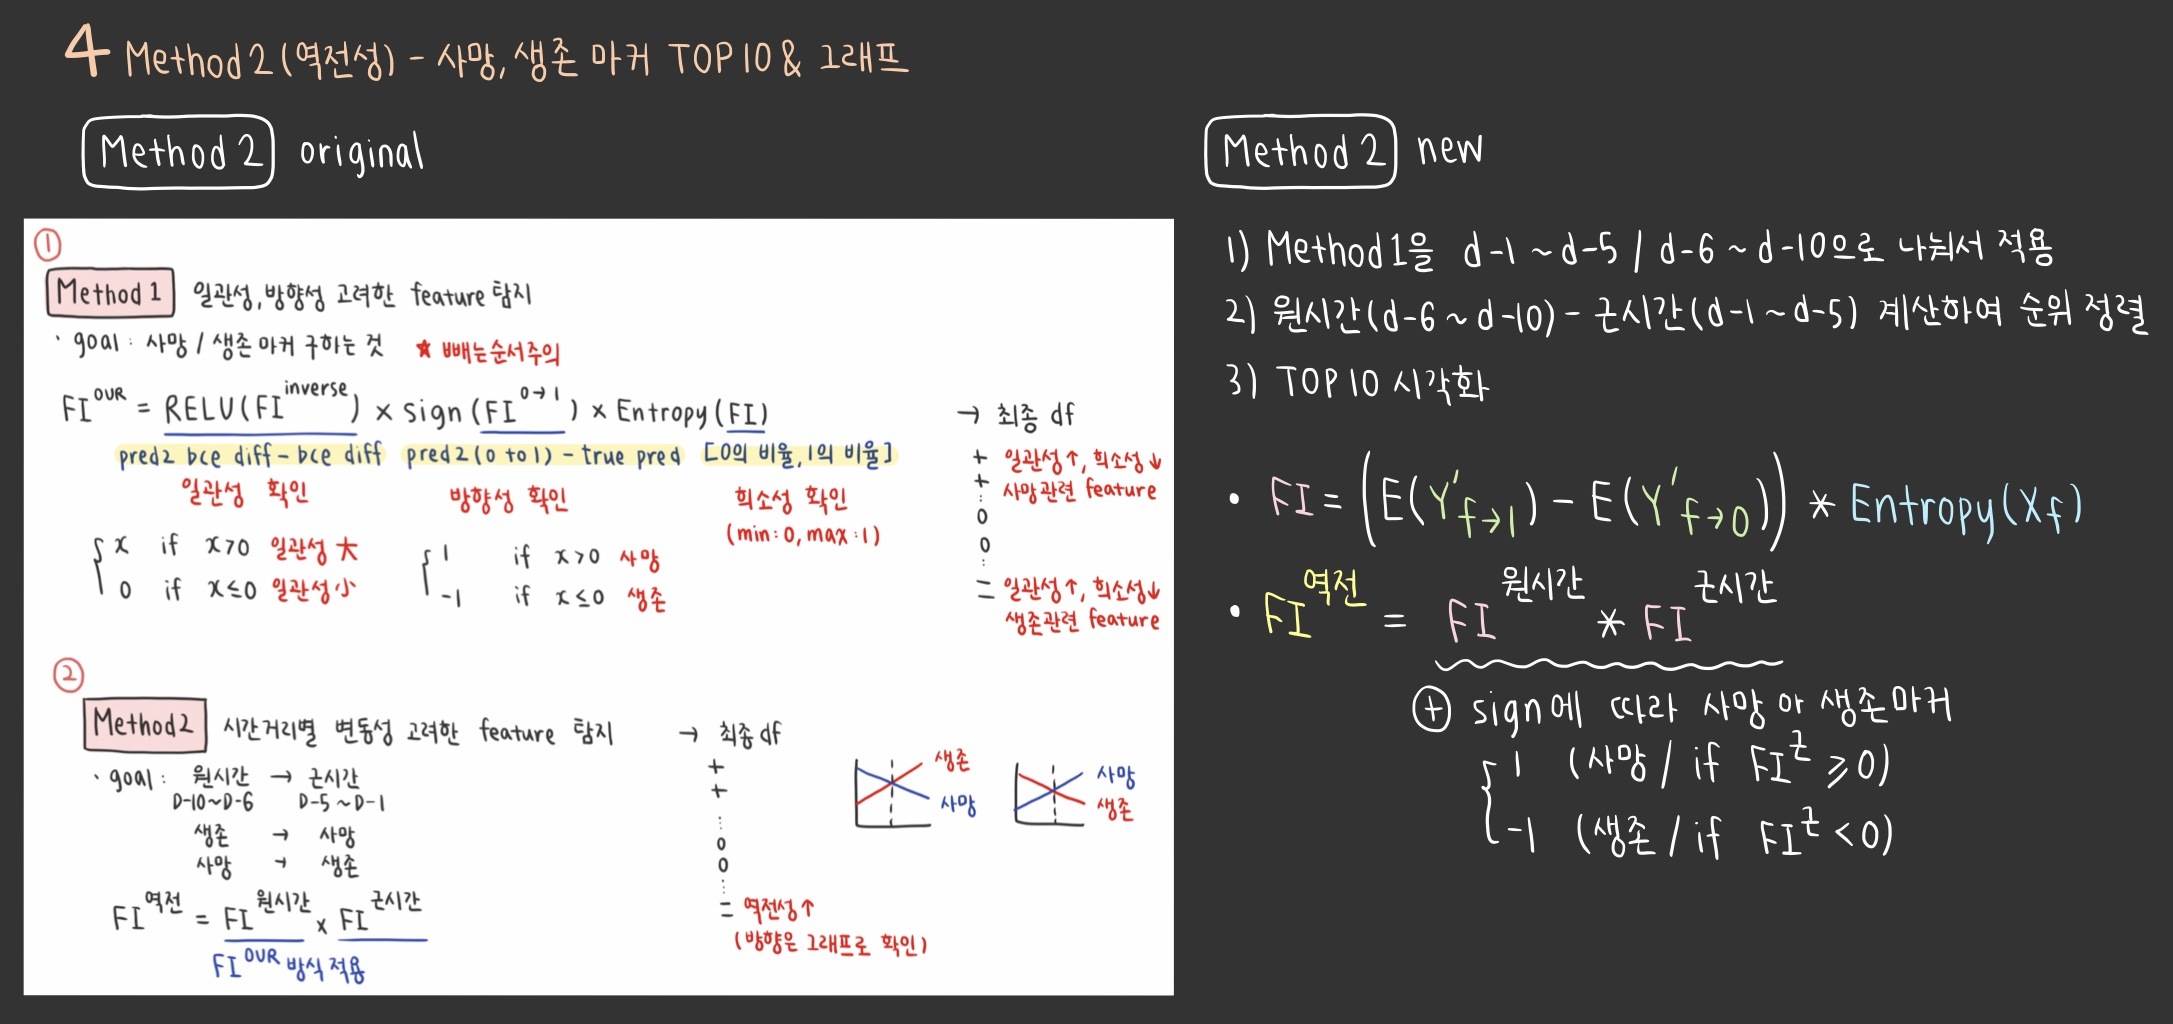

# M2_new

## x_(7727, 10, 3595)

In [5]:
# 1) DATA 
x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('total_data_7727_10_3595.csv')
features = total_data['ITEMID'].sort_values().unique()

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/f3595-06-val_loss:0.5522.hdf5') # 3595용 모델

results = []
with tf.device('/device:GPU:1'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) 원시간 : E(0to1) - E(1to0)
        x[:,:5,i] = 1
        원_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,:5,i] = 0
        원_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        # 4) 근시간 : E(0to1) - E(1to0)
        x[:,5:,i] = 1
        근_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,5:,i] = 0
        근_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        results.append({'feature':features[i], '원_mean_diff':원_mean_0to1-원_mean_1to0, '근_mean_diff':근_mean_0to1-근_mean_1to0})

  0%|          | 0/3595 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame(results)
df.to_csv('m2_df_3595.csv', index = False)

In [7]:
# 1. Entropy 구하기 -> 'entropy_3595.csv'로 저장

from scipy.stats import entropy

x = np.load('x_(7727,10,3595).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data_7727_10_3595.csv')
features = list(a['ITEMID'].sort_values().unique()) # 3595개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)
entropy_df.to_csv('entropy_3595.csv', index = False)

  0%|          | 0/3595 [00:00<?, ?it/s]

In [15]:
# 2. FI^역전 score가 포함된 df 생성

df1 = pd.read_csv('m2_df_3595.csv')
en_df = pd.read_csv('entropy_3595.csv')

m2_3595_score = pd.merge(df1, en_df, on = 'feature')
m2_3595_score['FI_원거리'] = m2_3595_score['원_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['FI_근거리'] = m2_3595_score['근_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['Sign'] = m2_3595_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_3595_score['FI_역전성'] = m2_3595_score['FI_원거리'] * m2_3595_score['FI_근거리']

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
190,51277,0.022620,0.092133,0.919332,0.020796,0.084701,1,0.001761
110,51006,0.015648,0.071670,0.980942,0.015350,0.070304,1,0.001079
52,50912,0.012732,0.053038,0.848272,0.010800,0.044990,1,0.000486
38,50893,0.009052,0.043241,0.891332,0.008068,0.038542,1,0.000311
31,50882,0.009896,0.046454,0.767764,0.007598,0.035666,1,0.000271
1929,409176230,0.018425,0.100652,0.380630,0.007013,0.038311,1,0.000269
94,50983,0.010462,0.043576,0.561714,0.005876,0.024477,1,0.000144
108,51003,0.015296,0.071515,0.329998,0.005048,0.023600,1,0.000119
19,50862,0.008993,0.046459,0.470553,0.004232,0.021862,1,0.000093
903,54848616,0.010743,0.041319,0.435895,0.004683,0.018011,1,0.000084


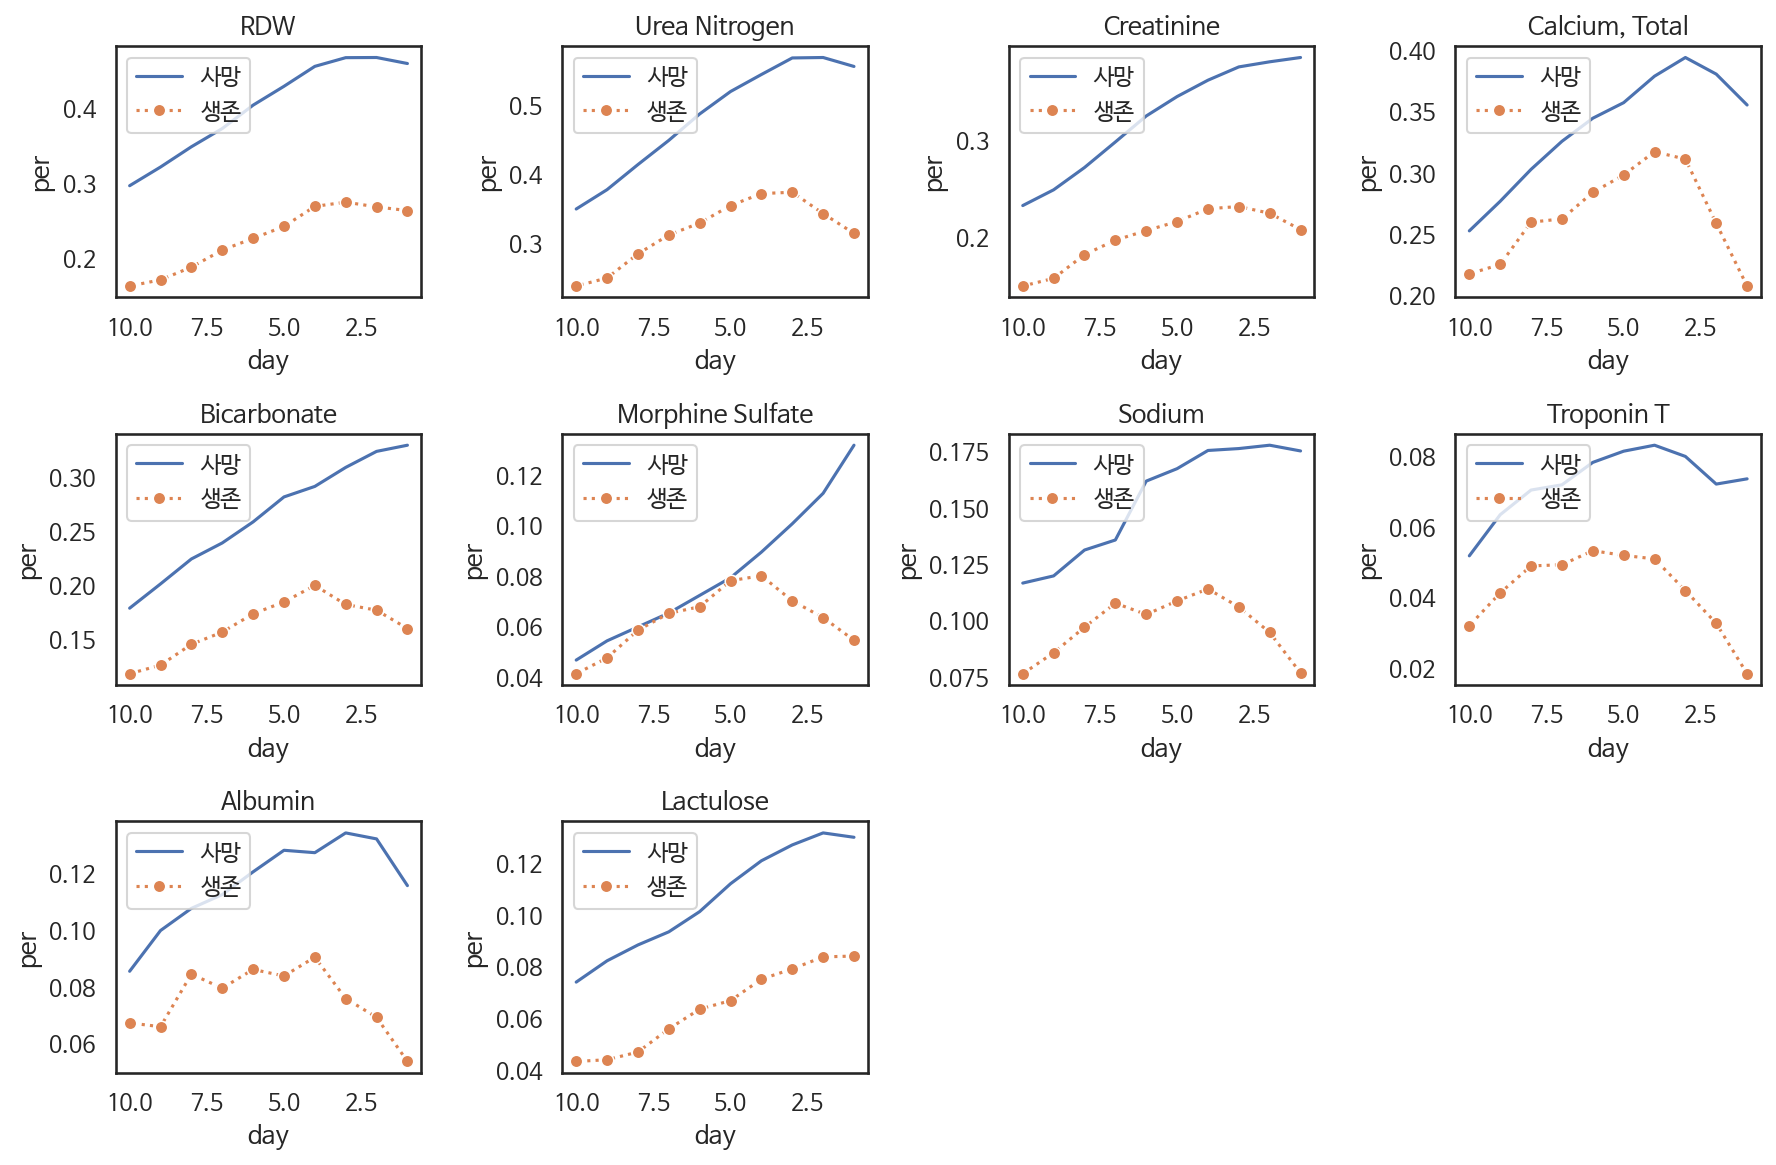

In [14]:
# 역전성 - 사망 마커 TOP10

m2_3595_사망 = m2_3595_score[m2_3595_score['Sign']==1].sort_values(by = 'FI_역전성', ascending = False)
m2_3595_사망[:10]
absum(m2_3595_사망[:10]['feature'])

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
2355,904516561,0.001385,-0.013199,0.735511,0.001019,-0.009708,-1,-9.892581e-06
2336,904224461,0.002230,-0.010638,0.557009,0.001242,-0.005926,-1,-7.360112e-06
2616,49502069724,0.002071,-0.003756,0.602292,0.001248,-0.002262,-1,-2.822607e-06
2104,536338101,0.002481,-0.005670,0.361956,0.000898,-0.002052,-1,-1.843066e-06
2423,8290036005,0.000358,-0.009244,0.490131,0.000176,-0.004531,-1,-7.959873e-07
1893,406055262,0.000982,-0.009814,0.267090,0.000262,-0.002621,-1,-6.875782e-07
3507,66553000401,0.000655,-0.005356,0.302693,0.000198,-0.001621,-1,-3.212563e-07
2720,51079004120,0.000467,-0.012905,0.223782,0.000105,-0.002888,-1,-3.020358e-07
932,56016975,0.001708,-0.003301,0.168746,0.000288,-0.000557,-1,-1.605315e-07
2347,904399061,0.004294,-0.000578,0.248676,0.001068,-0.000144,-1,-1.535050e-07


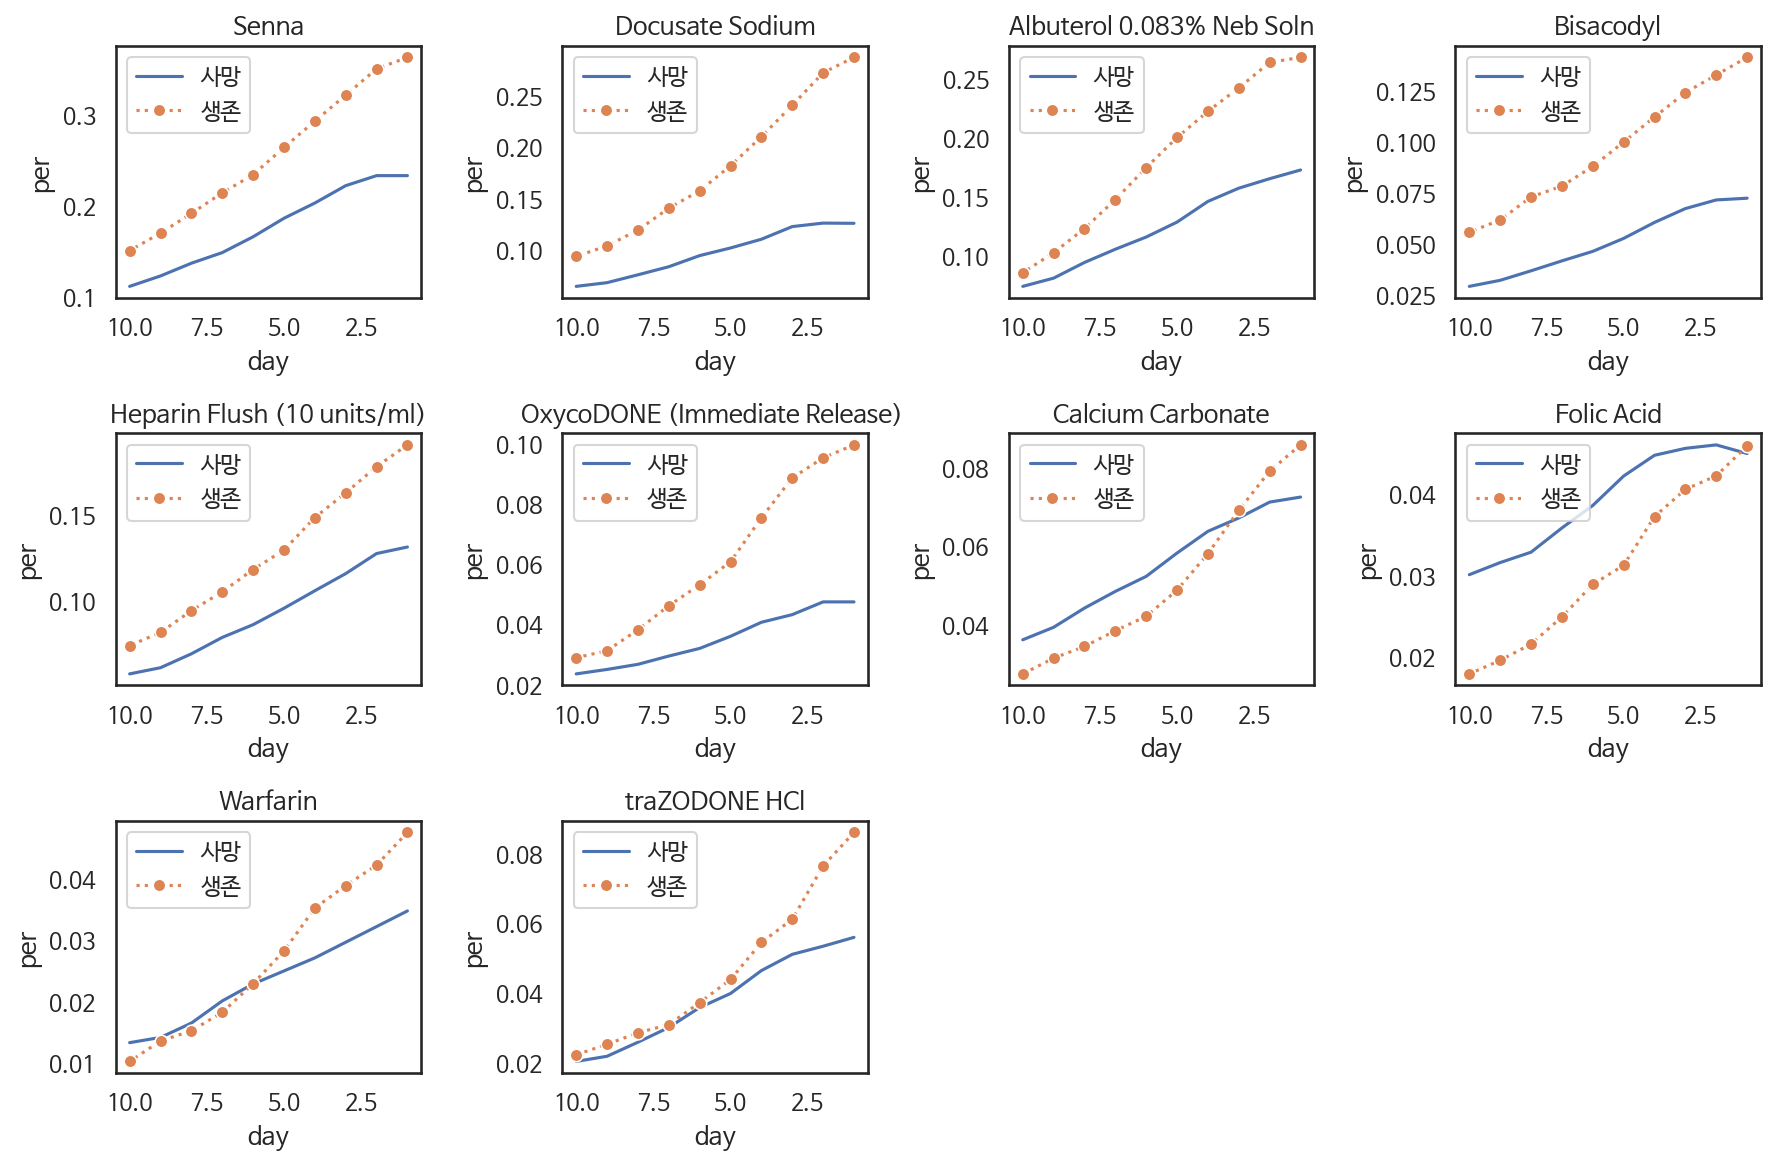

In [16]:
# 역전성 - 생존 마커 TOP10

m2_3595_생존 = m2_3595_score[m2_3595_score['Sign']==-1].sort_values(by = 'FI_역전성')
m2_3595_생존[:10]
absum(m2_3595_생존[:10]['feature'])

## x_(7727, 10, 4068)

In [ ]:
# 1) DATA 
x = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

total_data = pd.read_csv('/project/LSH/total_data_7727.csv')
features = total_data['ITEMID'].sort_values().unique()
print(len(features))

# 2) MODEL
from keras.models import load_model
lstm2 = load_model('./model/seed42-06-val_loss:0.5523.hdf5') # 4068용 모델

results = []
with tf.device('/device:GPU:0'):
    
    for i in tqdm(range(len(features))):

        save_col = x[:,:,i].copy()

        # 3) 원시간 : E(0to1) - E(1to0)
        x[:,:5,i] = 1
        원_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,:5,i] = 0
        원_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        # 4) 근시간 : E(0to1) - E(1to0)
        x[:,5:,i] = 1
        근_mean_0to1 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        x[:,5:,i] = 0
        근_mean_1to0 = np.mean(lstm2.predict(x, batch_size=10000, workers=-1, use_multiprocessing=True))
        
        x[:,:,i] = save_col
        
        results.append({'feature':features[i], '원_mean_diff':원_mean_0to1-원_mean_1to0, '근_mean_diff':근_mean_0to1-근_mean_1to0})
        
df = pd.DataFrame(results)
df.to_csv('m2_df_4068.csv', index = False)

4068


Using TensorFlow backend.


  0%|          | 0/4068 [00:00<?, ?it/s]

In [ ]:
# 1. Entropy 구하기 -> 'entropy_4068.csv'로 저장

from scipy.stats import entropy

x = np.load('x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

a = pd.read_csv('total_data.csv')
features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

results = []
for k in tqdm(range(len(features))):
    rate_1 = x[:,:,k].sum()/(7727*10)
    rate_0 = 1-rate_1
    k_entropy = entropy(np.array([rate_1, rate_0]), base = 2)
    
    results.append({'feature':features[k],'entropy':k_entropy})
    
entropy_df = pd.DataFrame(results)
entropy_df.to_csv('entropy_4068.csv', index = False)

In [ ]:
# 2. FI^역전 score가 포함된 df 생성

df1 = pd.read_csv('m2_df_4068.csv')
en_df = pd.read_csv('entropy_4068.csv')

m2_4068_score = pd.merge(df1, en_df, on = 'feature')
m2_4068_score['FI_원거리'] = m2_4068_score['원_mean_diff'] * m2_4068_score['entropy']
m2_4068_score['FI_근거리'] = m2_4068_score['근_mean_diff'] * m2_4068_score['entropy']
m2_4068_score['Sign'] = m2_4068_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_4068_score['FI_역전성'] = m2_4068_score['FI_원거리'] * m2_4068_score['FI_근거리']
m2_4068_score

# M2_특수 패턴
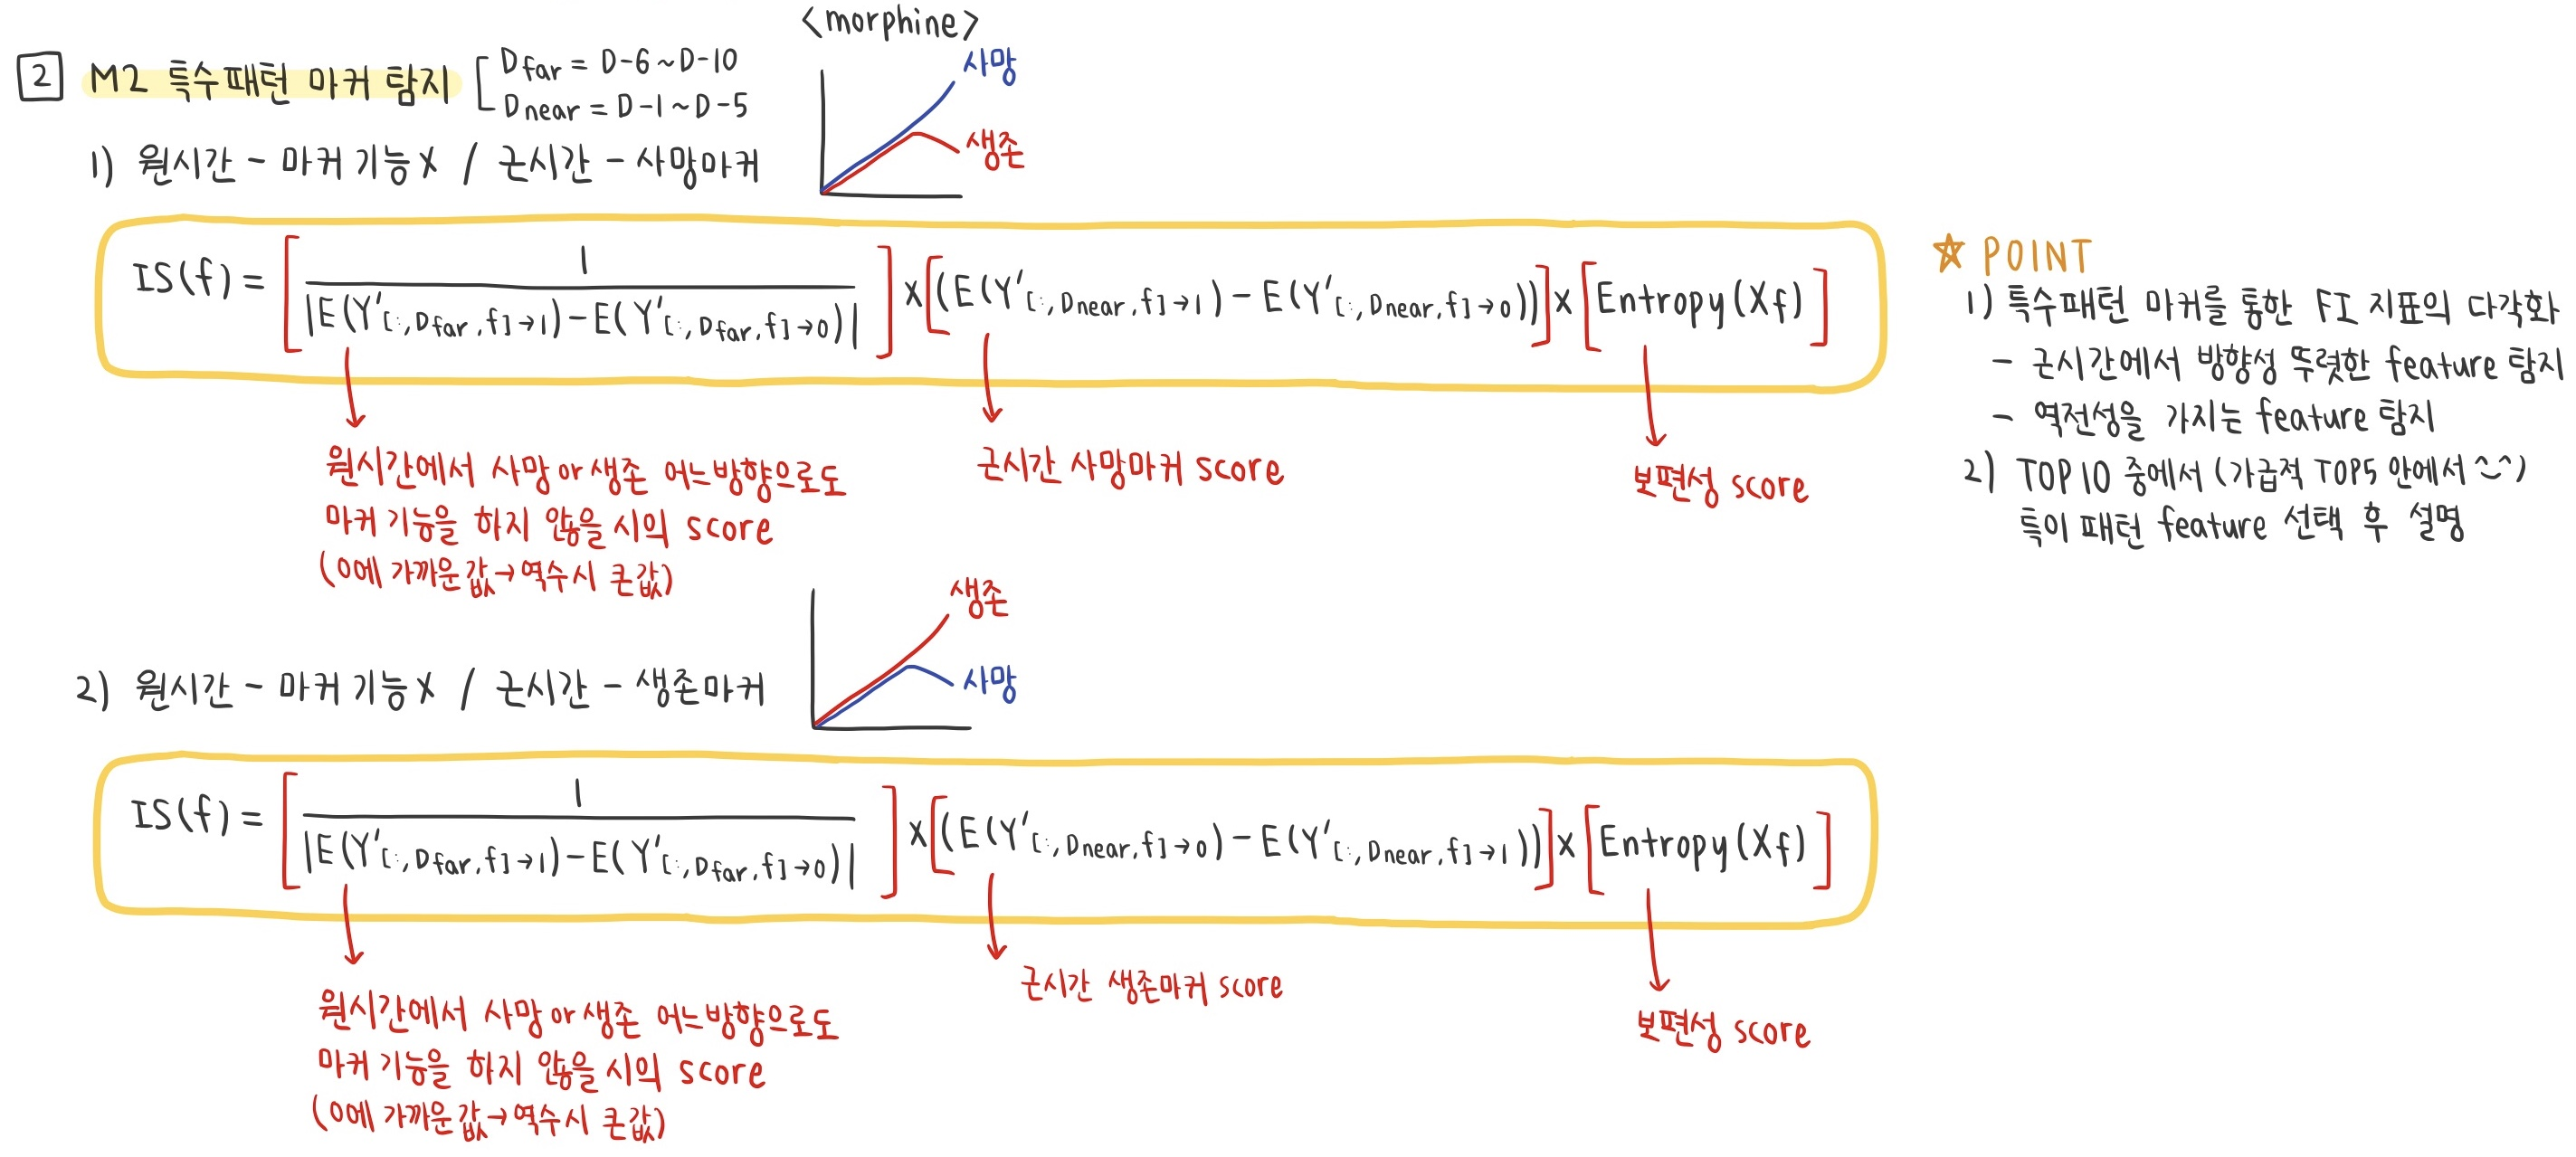

In [4]:
# 이용할 df
# '원_mean_diff':원_mean_0to1-원_mean_1to0
# '근_mean_diff':근_mean_0to1-근_mean_1to0

df1 = pd.read_csv('m2_df_3595.csv')
en_df = pd.read_csv('entropy_3595.csv')

m2_3595_score = pd.merge(df1, en_df, on = 'feature')
m2_3595_score['FI_원거리'] = m2_3595_score['원_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['FI_근거리'] = m2_3595_score['근_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['Sign'] = m2_3595_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_3595_score['FI_역전성'] = m2_3595_score['FI_원거리'] * m2_3595_score['FI_근거리']
m2_3595_score

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
0,0,-0.006517,-0.031630,0.894548,-0.005830,-0.028295,-1,1.649482e-04
1,50803,-0.004321,0.000232,0.033443,-0.000145,0.000008,1,-1.121181e-09
2,50804,-0.004819,0.024059,0.484874,-0.002336,0.011665,1,-2.725618e-05
3,50805,-0.003897,-0.015807,0.001172,-0.000005,-0.000019,-1,8.463197e-11
4,50806,0.001691,0.021856,0.074665,0.000126,0.001632,1,2.060664e-07
...,...,...,...,...,...,...,...,...
3590,74312001370,0.003651,0.015593,0.008062,0.000029,0.000126,1,3.700223e-09
3591,78112001103,-0.002105,-0.014361,0.036891,-0.000078,-0.000530,-1,4.113738e-08
3592,87701071218,0.005253,0.020201,0.057111,0.000300,0.001154,1,3.460835e-07
3593,87701083336,-0.000825,-0.007062,0.011373,-0.000009,-0.000080,-1,7.531657e-10


## 원시간 - 마커 기능 X / 근시간 - 사망 마커

In [12]:
# 1) 근시간 - 사망 마커
df1 = m2_3595_score.copy()
df1['1항'] = 1 / abs(df1['원_mean_diff'])
df1['2항'] = df1['근_mean_diff']
df1['3항'] = df1['entropy']
df1['근시간_사망마커'] = df1['1항'] * df1['2항'] * df1['3항']

# 2) 근시간 - 생존 마커
df1['근시간_생존마커'] = -df1['근시간_사망마커']

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성,1항,2항,3항,근시간_사망마커
3299,61553011841,-0.000030,0.016760,0.120014,-3.641069e-06,0.002011,1,-7.323648e-09,32961.131631,0.016760,0.120014,66.298044
2119,548301200,0.000004,0.001179,0.161232,7.111531e-07,0.000190,1,1.352100e-10,226719.135135,0.001179,0.161232,43.105600
248,51457,0.000011,0.011425,0.033548,3.539335e-07,0.000383,1,1.356542e-10,94786.531073,0.011425,0.033548,36.329399
1785,338004902,0.000543,0.027033,0.613247,3.329187e-04,0.016578,1,5.519025e-06,1842.030742,0.027033,0.613247,30.536622
1772,338001703,0.000161,0.016457,0.295210,4.756168e-05,0.004858,1,2.310745e-07,6206.887162,0.016457,0.295210,30.155648
1691,206886202,0.000097,0.011399,0.248735,2.421044e-05,0.002835,1,6.864324e-08,10273.861604,0.011399,0.248735,29.129222
1790,338004938,-0.000461,0.020315,0.576259,-2.653706e-04,0.011707,1,-3.106643e-06,2171.526793,0.020315,0.576259,25.421649
2255,713016550,-0.000190,0.006727,0.388181,-7.392400e-05,0.002611,1,-1.930317e-07,5251.084820,0.006727,0.388181,13.711727
1419,121075210,-0.000002,0.002412,0.012398,-2.955814e-08,0.000030,1,-8.838401e-13,419430.400000,0.002412,0.012398,12.541704
3047,54569523500,-0.001037,0.024889,0.471125,-4.884172e-04,0.011726,1,-5.727057e-06,964.595872,0.024889,0.471125,11.310608


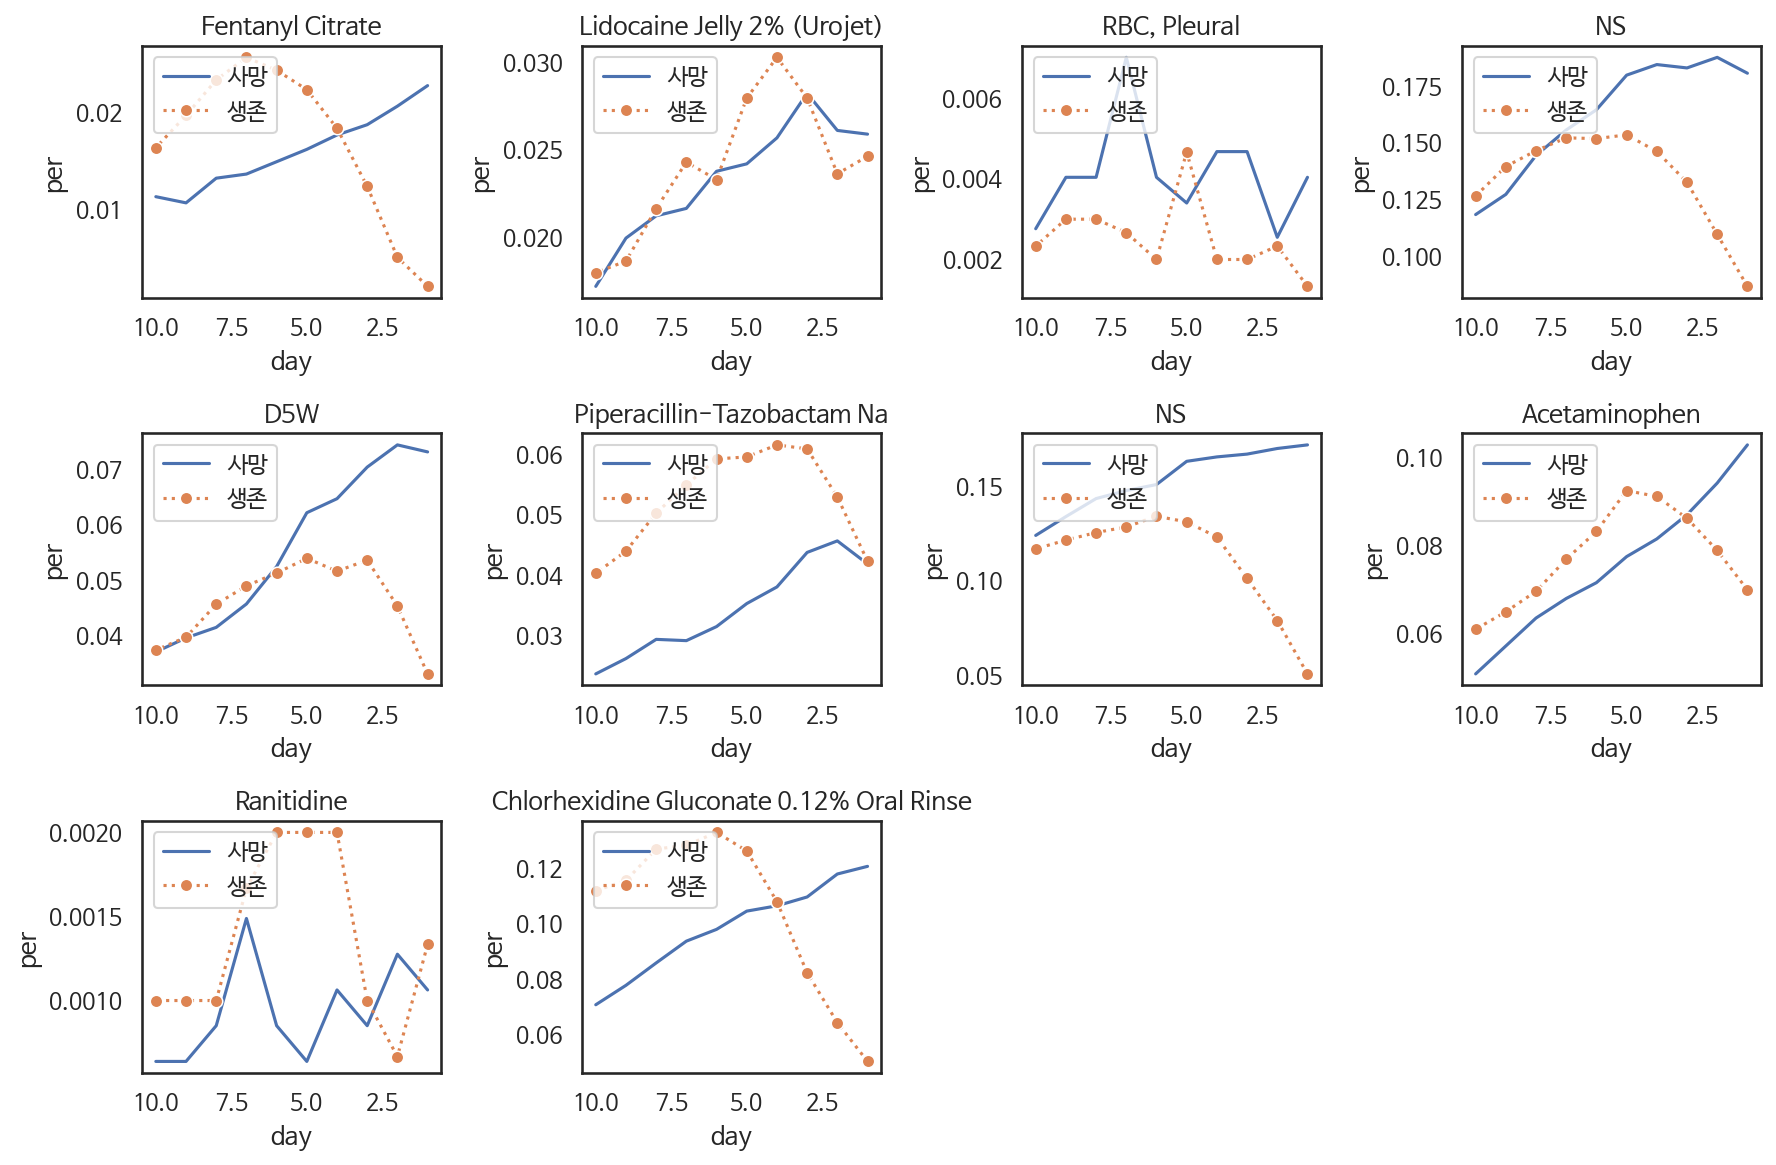

In [11]:
df1 = df1.sort_values(by = '근시간_사망마커', ascending = False)
df1[:10]
absum(df1[:10]['feature'])

## 원시간 - 마커 기능 X / 근시간 - 생존 마커

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성,1항,2항,3항,근시간_사망마커,근시간_생존마커
479,6011728,-4.947186e-06,-0.006195,0.094005,-4.650608e-07,-5.823290e-04,-1,2.708184e-10,2.021351e+05,-0.006195,0.094005,-117.709142,117.709142
3264,60505251903,-2.688169e-05,-0.005145,0.186009,-5.000226e-06,-9.570942e-04,-1,4.785687e-09,3.720004e+04,-0.005145,0.186009,-35.603939,35.603939
2321,904053061,-1.335740e-04,-0.014718,0.258448,-3.452188e-05,-3.803877e-03,-1,1.313170e-07,7.486486e+03,-0.014718,0.258448,-28.477672,28.477672
161,51222,-3.963709e-04,-0.008015,0.938222,-3.718838e-04,-7.519881e-03,-1,2.796522e-06,2.522890e+03,-0.008015,0.938222,-18.971830,18.971830
191,51279,-6.465912e-04,-0.010503,0.932668,-6.030547e-04,-9.795636e-03,-1,5.907304e-06,1.546572e+03,-0.010503,0.932668,-15.149658,15.149658
971,67014568,-1.132488e-05,-0.005858,0.028287,-3.203514e-07,-1.657195e-04,-1,5.308847e-11,8.830114e+04,-0.005858,0.028287,-14.633218,14.633218
416,3085222,-1.192093e-07,-0.000866,0.001858,-2.215144e-10,-1.609302e-06,-1,3.564837e-16,8.388608e+06,-0.000866,0.001858,-13.499807,13.499807
2423,8290036005,3.584623e-04,-0.009244,0.490131,1.756934e-04,-4.530547e-03,-1,-7.959873e-07,2.789693e+03,-0.009244,0.490131,-12.638837,12.638837
160,51221,-1.518846e-03,-0.015939,0.938478,-1.425404e-03,-1.495852e-02,-1,2.132192e-05,6.583948e+02,-0.015939,0.938478,-9.848609,9.848609
453,4035009,5.960464e-08,-0.000706,0.000812,4.838190e-11,-5.731320e-07,-1,-2.772922e-17,1.677722e+07,-0.000706,0.000812,-9.615560,9.615560


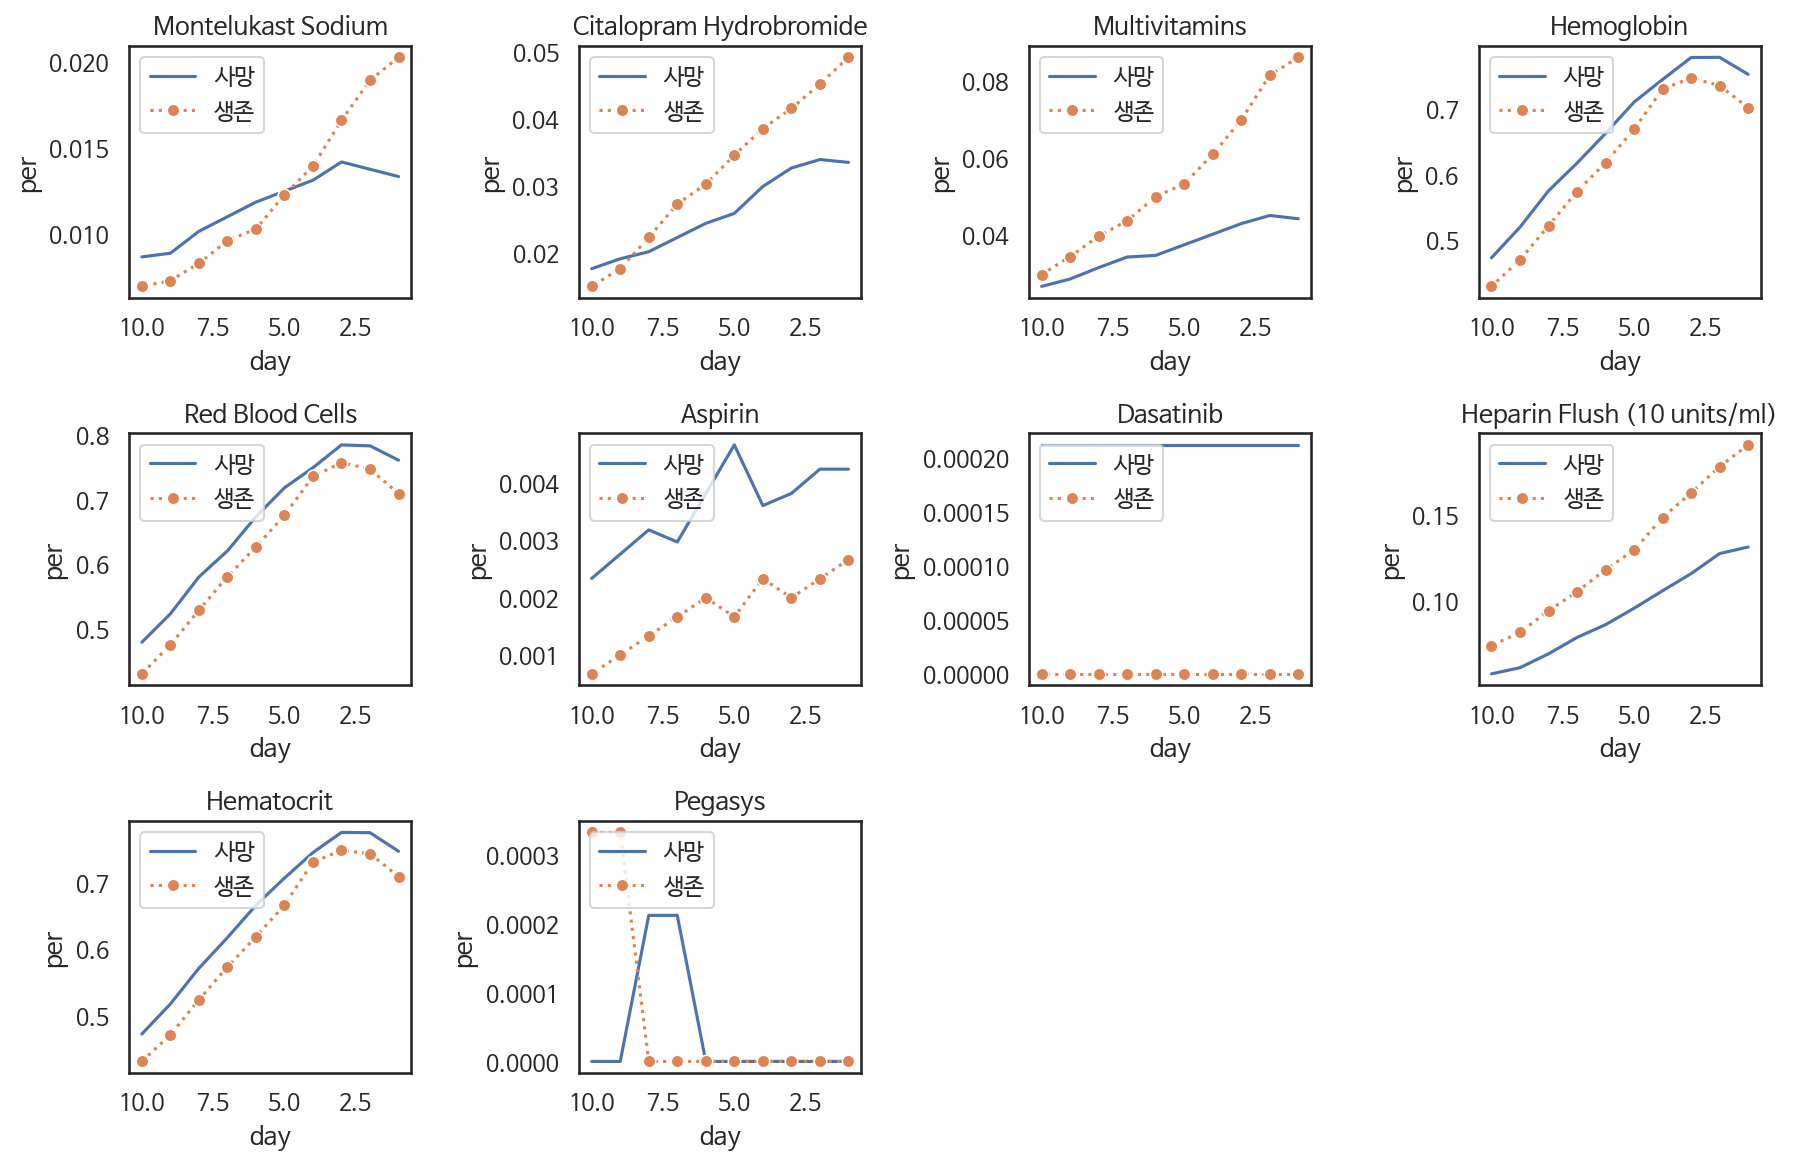

In [13]:
df1 = df1.sort_values(by = '근시간_생존마커', ascending = False)
df1[:10]
absum(df1[:10]['feature'])

## 원시간 - 생존 마커 / 근시간 - 사망 마커

In [19]:
# relu 함수 정의
def relu(x):
    return np.maximum(0, x)

# 이용할 df
# '원_mean_diff':원_mean_0to1-원_mean_1to0
# '근_mean_diff':근_mean_0to1-근_mean_1to0

df1 = pd.read_csv('m2_df_3595.csv')
en_df = pd.read_csv('entropy_3595.csv')

m2_3595_score = pd.merge(df1, en_df, on = 'feature')
m2_3595_score['FI_원거리'] = m2_3595_score['원_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['FI_근거리'] = m2_3595_score['근_mean_diff'] * m2_3595_score['entropy']
m2_3595_score['Sign'] = m2_3595_score['FI_근거리'].apply(lambda x:1 if x>=0 else -1)
m2_3595_score['FI_역전성'] = m2_3595_score['FI_원거리'] * m2_3595_score['FI_근거리']
m2_3595_score

,feature,원_mean_diff,근_mean_diff,entropy,FI_원거리,FI_근거리,Sign,FI_역전성
0,0,-0.006517,-0.031630,0.894548,-0.005830,-0.028295,-1,1.649482e-04
1,50803,-0.004321,0.000232,0.033443,-0.000145,0.000008,1,-1.121181e-09
2,50804,-0.004819,0.024059,0.484874,-0.002336,0.011665,1,-2.725618e-05
3,50805,-0.003897,-0.015807,0.001172,-0.000005,-0.000019,-1,8.463197e-11
4,50806,0.001691,0.021856,0.074665,0.000126,0.001632,1,2.060664e-07
...,...,...,...,...,...,...,...,...
3590,74312001370,0.003651,0.015593,0.008062,0.000029,0.000126,1,3.700223e-09
3591,78112001103,-0.002105,-0.014361,0.036891,-0.000078,-0.000530,-1,4.113738e-08
3592,87701071218,0.005253,0.020201,0.057111,0.000300,0.001154,1,3.460835e-07
3593,87701083336,-0.000825,-0.007062,0.011373,-0.000009,-0.000080,-1,7.531657e-10


In [28]:
df1 = m2_3595_score[['feature', '원_mean_diff', '근_mean_diff', 'entropy']]
df1['mfar0-mfar1'] = -df1['원_mean_diff']
df1['원생근사'] = relu(df1['mfar0-mfar1']) * relu(df1['근_mean_diff']) * df1['entropy']
df1

<ipython-input-28-1e3aab2374bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mfar0-mfar1'] = -df1['원_mean_diff']
<ipython-input-28-1e3aab2374bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['원생근사'] = relu(df1['mfar0-mfar1']) * relu(df1['근_mean_diff']) * df1['entropy']


,feature,원_mean_diff,근_mean_diff,entropy,mfar0-mfar1,원생근사
0,0,-0.006517,-0.031630,0.894548,0.006517,0.000000e+00
1,50803,-0.004321,0.000232,0.033443,0.004321,3.352558e-08
2,50804,-0.004819,0.024059,0.484874,0.004819,5.621293e-05
3,50805,-0.003897,-0.015807,0.001172,0.003897,0.000000e+00
4,50806,0.001691,0.021856,0.074665,-0.001691,0.000000e+00
...,...,...,...,...,...,...
3590,74312001370,0.003651,0.015593,0.008062,-0.003651,0.000000e+00
3591,78112001103,-0.002105,-0.014361,0.036891,0.002105,0.000000e+00
3592,87701071218,0.005253,0.020201,0.057111,-0.005253,0.000000e+00
3593,87701083336,-0.000825,-0.007062,0.011373,0.000825,0.000000e+00


,feature,원_mean_diff,근_mean_diff,entropy,mfar0-mfar1,원생근사
12,50821,-0.006726,0.017790,0.692884,0.006726,0.000083
10,50818,-0.007734,0.013078,0.590515,0.007734,0.000060
2,50804,-0.004819,0.024059,0.484874,0.004819,0.000056
11,50820,-0.002847,0.029832,0.557222,0.002847,0.000047
5,50808,-0.003155,0.027627,0.342257,0.003155,0.000030
2443,10019003783,-0.003961,0.021462,0.316341,0.003961,0.000027
6,50809,-0.002504,0.034943,0.306320,0.002504,0.000027
2433,10019002710,-0.005389,0.011400,0.300817,0.005389,0.000018
1771,338001702,-0.001242,0.019949,0.688007,0.001242,0.000017
334,225752,-0.002294,0.019153,0.350231,0.002294,0.000015


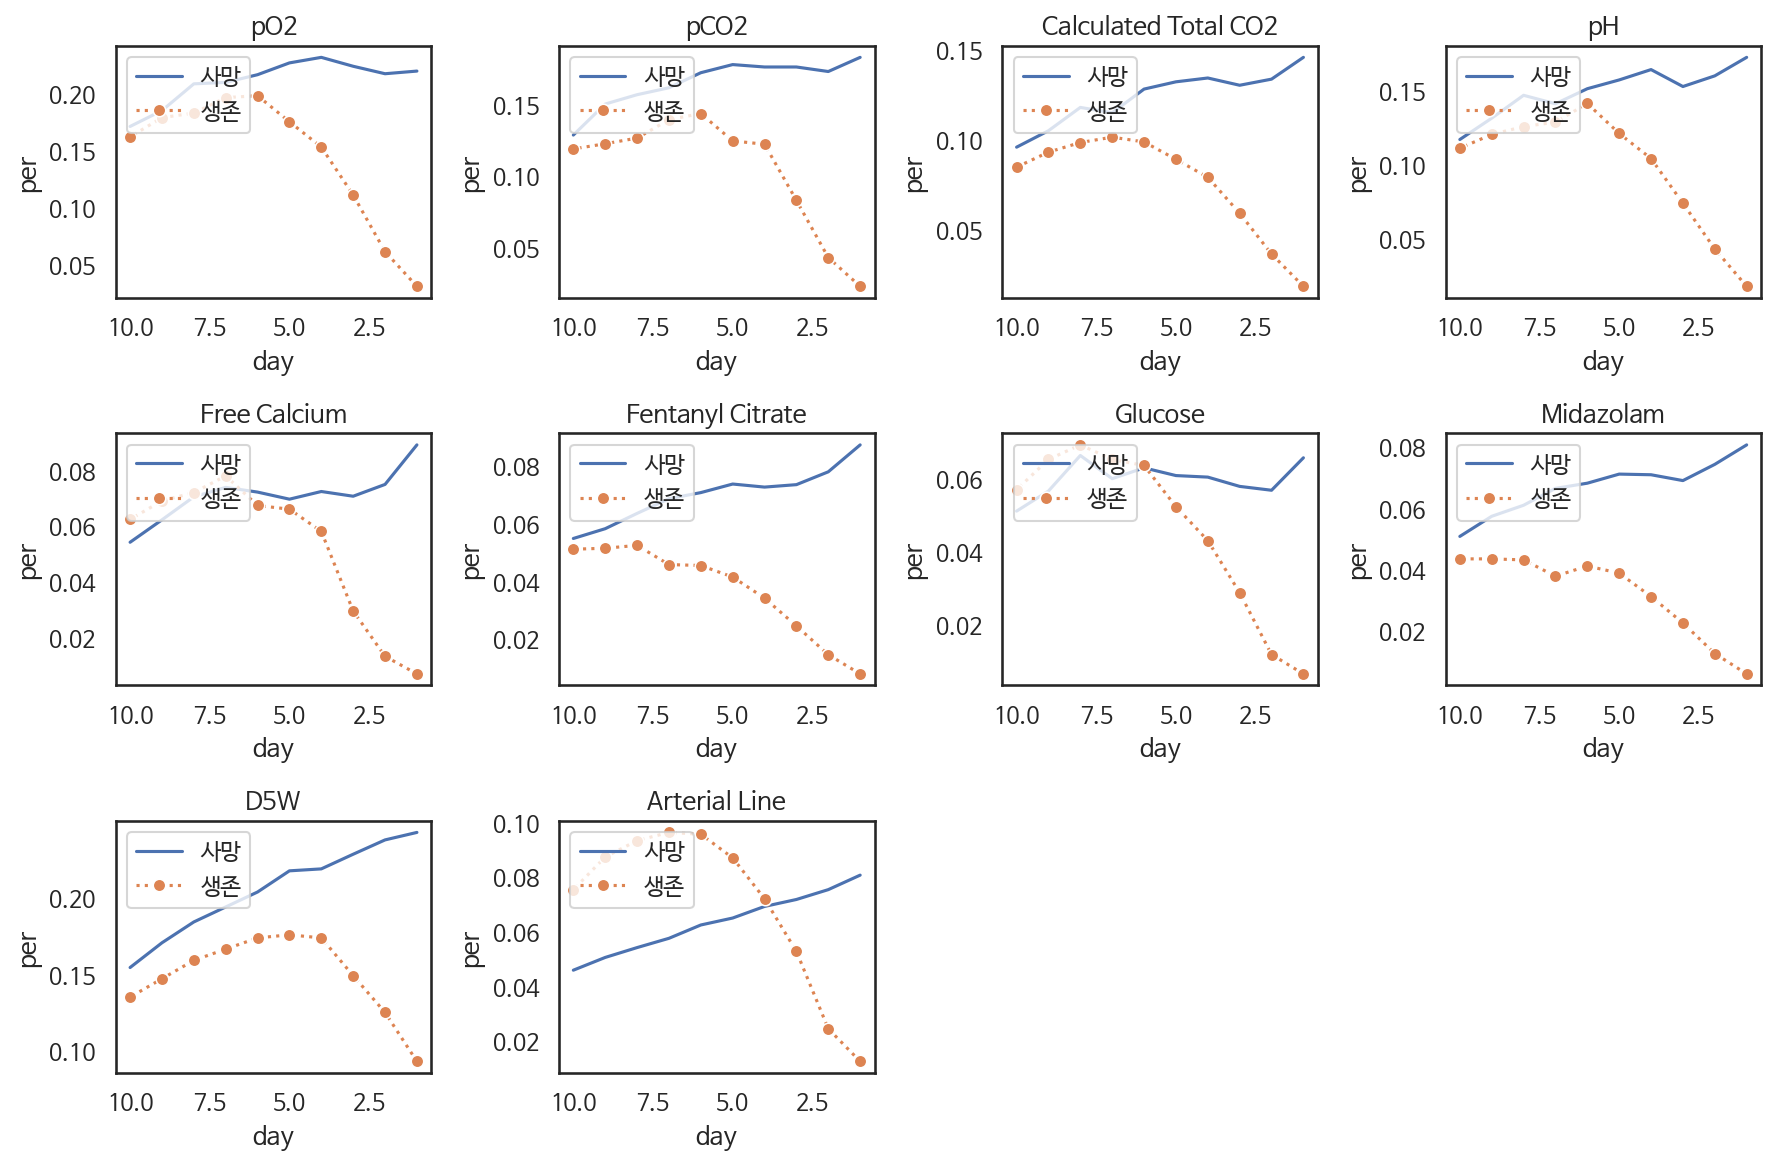

In [29]:
df1 = df1.sort_values(by = '원생근사', ascending = False)
df1[:10]
absum(df1[:10]['feature'])

## 원시간 - 사망 마커 / 근시간 - 생존 마커
- 원사근생 모든 값이 0이 나옴


In [33]:
df1 = m2_3595_score[['feature', '원_mean_diff', '근_mean_diff', 'entropy']]
df1['mnear0-mnear1'] = -df1['근_mean_diff']
df1['원사근생'] = relu(df1['원_mean_diff']) * relu(df1['mnear0-mnear1']) * df1['entropy']
df1

<ipython-input-33-7dd49da4149c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mnear0-mnear1'] = -df1['근_mean_diff']
<ipython-input-33-7dd49da4149c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['원사근생'] = relu(df1['원_mean_diff']) * relu(df1['mnear0-mnear1']) * df1['entropy']


,feature,원_mean_diff,근_mean_diff,entropy,mnear0-mnear1,원사근생
0,0,-0.006517,-0.031630,0.894548,0.031630,0.0
1,50803,-0.004321,0.000232,0.033443,-0.000232,0.0
2,50804,-0.004819,0.024059,0.484874,-0.024059,0.0
3,50805,-0.003897,-0.015807,0.001172,0.015807,0.0
4,50806,0.001691,0.021856,0.074665,-0.021856,0.0
...,...,...,...,...,...,...
3590,74312001370,0.003651,0.015593,0.008062,-0.015593,0.0
3591,78112001103,-0.002105,-0.014361,0.036891,0.014361,0.0
3592,87701071218,0.005253,0.020201,0.057111,-0.020201,0.0
3593,87701083336,-0.000825,-0.007062,0.011373,0.007062,0.0


,feature,원_mean_diff,근_mean_diff,entropy,mnear0-mnear1,원사근생
2355,904516561,0.001385,-0.013199,0.735511,0.013199,1.344994e-05
2336,904224461,0.002230,-0.010638,0.557009,0.010638,1.321364e-05
2104,536338101,0.002481,-0.005670,0.361956,0.005670,5.091965e-06
2616,49502069724,0.002071,-0.003756,0.602292,0.003756,4.686444e-06
1893,406055262,0.000982,-0.009814,0.267090,0.009814,2.574327e-06
2423,8290036005,0.000358,-0.009244,0.490131,0.009244,1.624030e-06
2720,51079004120,0.000467,-0.012905,0.223782,0.012905,1.349690e-06
2894,51079090520,0.001845,-0.011931,0.048714,0.011931,1.072431e-06
3507,66553000401,0.000655,-0.005356,0.302693,0.005356,1.061328e-06
499,6096328,0.003829,-0.001945,0.131560,0.001945,9.797138e-07


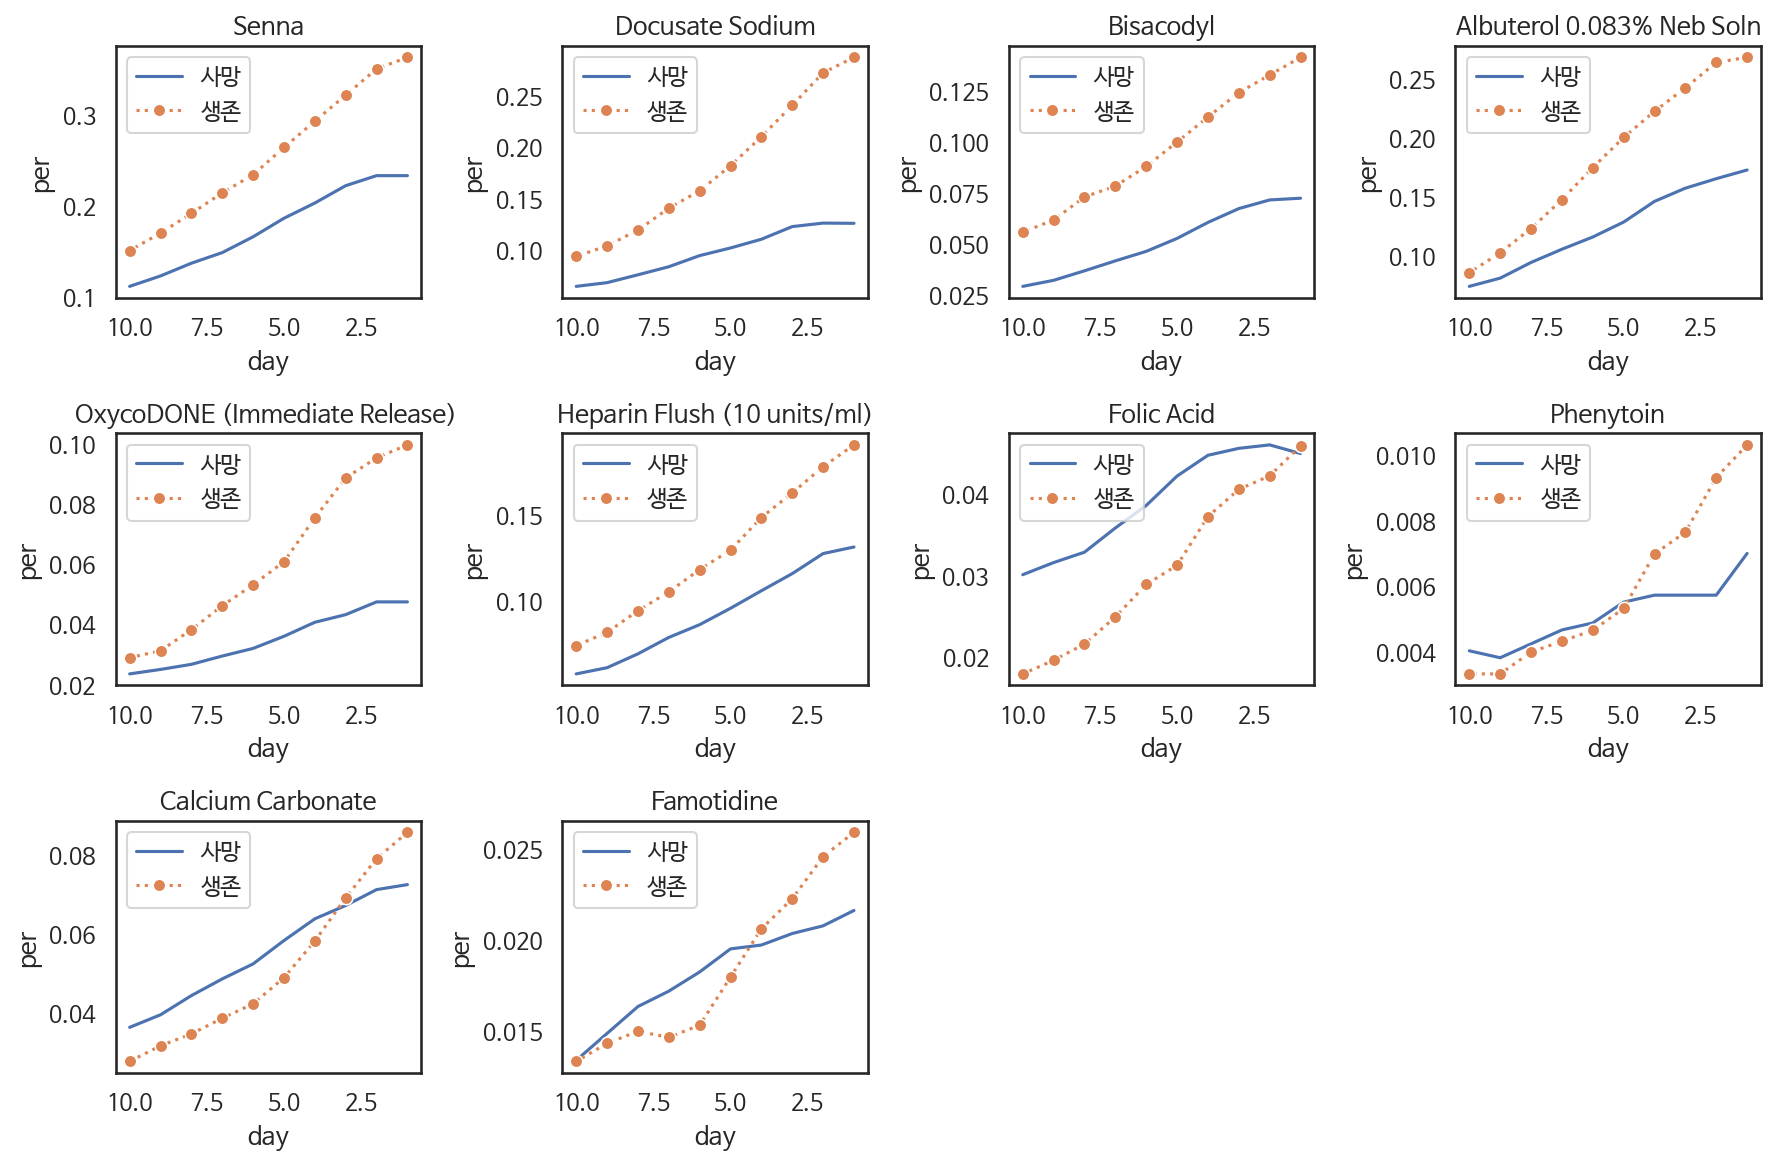

In [34]:
df1 = df1.sort_values(by = '원사근생', ascending = False)
df1[:10]
absum(df1[:10]['feature'])